In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
PATH_SOURCE = "/home/jbassham/jack/data/weddell/1992_2020"
PATH_DEST = PATH_SOURCE
HEM = "sh" # nh or sh
START_YEAR = 1992
END_YEAR = 2020

In [4]:
fnam = "motion_ppv4_latlon_sh_1992_2020.npz"

data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ui = data['u'] # zonal ice velocity
vi = data['v'] # meridional ice velocity
uc = data['error']
lat = data['lat']
lon = data['lon']
time = data['time']

In [27]:
fnam = "con_nimbus7_latlon_sh_1992_2020.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ic = data['ic'] # zonal ice velocity

In [6]:
fnam = "wind_JRA55_latlon_global_1992_2020.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
uw = data['u']
vw = data['v']

In [28]:
# Mask ice concentration

ic_raw = np.round(ic * 250)

# Mask 
# 251 pole hole
# 252 unused data
# 253 coastline
# 254 land
ic = np.where((ic_raw == 251) | (ic_raw == 252) | (ic_raw == 253) | (ic_raw == 254), np.nan, ic)

# Filter points with ice error greater than 999 and 0 concentration ice motion
# Create mask
mask = (ic == 0) | (np.isnan(ic)) | (uc >= 999) | (uc <= -999)

# Mask points
ui = np.where(mask, np.nan, ui) 
uv = np.where(mask, np.nan, vi)

In [9]:
# Shift present day parameters forward one day
ui_today = ui[1:,:,:]
vi_today = vi[1:,:,:]
uw_today = uw[1:,:,:]
vw_today = vw[1:,:,:]
time_today = time[1:]
uc_today = uc[1:,:,:]

# # Remove last day from previous day parameters
# ui_yester = ui[-1:,:,:]
# vi_yester = vi[-1:,:,:]
ic_yester = ic[:-1,:,:]
time_yester = time[:-1]

In [10]:
# NOTE:
# norm here might be incorrect! 
# The problem could be here that we're normlazing outside of the loop (with the whole grid) without specifiying normalizing accross the time dimension

def norm(data):
    
    data_mean = np.nanmean(data)
    data_std = np.nanstd(data)
    data_norm = (data - data_mean)/data_std
    
    return data_norm, data_mean, data_std

In [11]:
print(np.shape(uw))

(10593, 81, 522)


In [12]:
# Normalize data
ui_today, ui_mean, ui_std = norm(ui_today)
vi_today, vi_mean, vi_std = norm(vi_today)
uw_today, uw_mean, uw_std = norm(uw_today)
vw_today, uw_mean, uw_std = norm(vw_today)
ic_yester, ic_mean, ic_std = norm(ic_yester)

In [13]:
# print(np.shape(ui_today))
# plt.pcolormesh(ui_today[0,:,:])
# plt.show()
# plt.pcolormesh(ui[1,:,:])
# plt.show()

In [14]:
# Create dimensions for arrays based on lat lon grid
dims = np.shape(ui_today)
nt = dims[0]
ny = dims[1]
nx = dims[2]
dim = (ny, nx)

# Initialize fit array
u_true = np.zeros((nt, ny, nx))
v_true = np.zeros((nt, ny, nx))
u_pred = np.zeros((nt, ny, nx))
v_pred = np.zeros((nt, ny, nx))

m1 = np.zeros((dim), dtype=np.complex64) # gridwise model parameter present day wind
m2 = np.zeros((dim), dtype=np.complex64) # gridwise model parameter previous day ice concentration

In [ ]:
# Iterate through lat and lon points
for iy in range(len(lat)):
    for ix in range(len(lon)):
        
        # If all NaN values in motion vectors (NaN evaluetes to 'True' b/c not equal to 0)
        if np.all(np.isnan(ui_today[:,iy, ix]) | np.isnan(vi_today[:,iy,ix])):
            # Set arrays equal to NaN and continue to next iteration
            m1[iy,ix] = np.nan
            m2[iy,ix] = np.nan
            
            u_true[:,iy,ix] = np.nan
            v_true[:,iy,ix] = np.nan  
            u_pred[:,iy,ix] = np.nan
            v_pred[:,iy,ix] = np.nan
            
            continue

        else:
            try:          
                # Find NaN indices from ice motion set
                inan = np.where(np.isnan(ui_today[:,iy, ix]) | np.isnan(vi_today[:,iy,ix]))
                
                # Create NaN mask
                # Initialize mask shape of grid (initializes to true - inclusion)
                nmask = np.ones_like(ui_today[:,iy,ix], dtype=bool)
                # Set nan values to false
                nmask[inan] = False
                
                # Filter ice motion
                ui_to = ui_today[nmask,iy,ix]
                vi_to = vi_today[nmask,iy,ix]
                
                # Take Wind and Concentration at same filter indices
                uw_to = uw_today[nmask,iy,ix]
                vw_to = vw_today[nmask,iy,ix]
                
                ic_ye = ic_yester[nmask,iy,ix]
                
                
                # Filter dates non nan
                time_to = time_today[nmask]
                
                # Save in true array
                u_true[nmask, iy, ix] = ui_to
                v_true[nmask, iy, ix] = vi_to
                
                u_true[inan, iy, ix] = np.nan
                v_true[inan, iy, ix] = np.nan
    
                # Convert to complex; 1j is python imaginary operator
                ivel = ui_to + vi_to*1j # Complex Present Day Ice Motion
                w = uw_to + vw_to*1j # Complex Present Day Wind
                ic = ic_ye + 0*1j # Complex Previous Day Concentration (imag comp set to 0)
    
                # Create input G matrix of Wind and Concentration (Transpose)
                G = np.array([w, ic]).T
    
                # Create data matrix of ice motion data points over time
        
                # COMPLEX CONJUGATE TRANSPOSE?!?!?!?!
                d = np.atleast_2d(ivel).T
    
                # Initialize vector of model parameters
                m = np.atleast_2d(np.array([np.zeros(2)])).T
    
                ### LR, No Ridge Parameter *(With Complex Conjugate Transpose)
                # Present Day Wind, Previous day concentration independent
                # Present Day Ice Motion, dependent
                m = (np.linalg.inv(G.conj().T@G))@G.conj().T@d
    
                # Extract Coefficients
                m1[iy,ix] = m[0]
                m2[iy,ix] = m[1]
    
                fit = G@m

                u_pred[nmask, iy, ix] = np.real(fit).flatten()
                v_pred[nmask, iy, ix] = np.imag(fit).flatten()
            
                u_pred[inan, iy, ix] = np.nan
                v_pred[inan, iy, ix] = np.nan
    
            except Exception as e:
                print(f"Error at iy={iy}, ix={ix}: {e}")

    print(f"lat: {iy} complete")

lat: 0 complete
lat: 1 complete
lat: 2 complete
lat: 3 complete
lat: 4 complete
lat: 5 complete
lat: 6 complete


/tmp/ipykernel_24338/1509902605.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m1[iy,ix] = m[0]
/tmp/ipykernel_24338/1509902605.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m2[iy,ix] = m[1]


lat: 7 complete
lat: 8 complete
lat: 9 complete
lat: 10 complete
lat: 11 complete
lat: 12 complete
lat: 13 complete
lat: 14 complete
lat: 15 complete
lat: 16 complete
lat: 17 complete
lat: 18 complete
lat: 19 complete
lat: 20 complete
lat: 21 complete
lat: 22 complete
lat: 23 complete
lat: 24 complete
lat: 25 complete
lat: 26 complete
lat: 27 complete
lat: 28 complete
lat: 29 complete
lat: 30 complete
lat: 31 complete
lat: 32 complete
lat: 33 complete
lat: 34 complete
lat: 35 complete
lat: 36 complete
lat: 37 complete
lat: 38 complete
lat: 39 complete
lat: 40 complete
lat: 41 complete
lat: 42 complete
lat: 43 complete
lat: 44 complete
lat: 45 complete
lat: 46 complete
lat: 47 complete
lat: 48 complete
lat: 49 complete


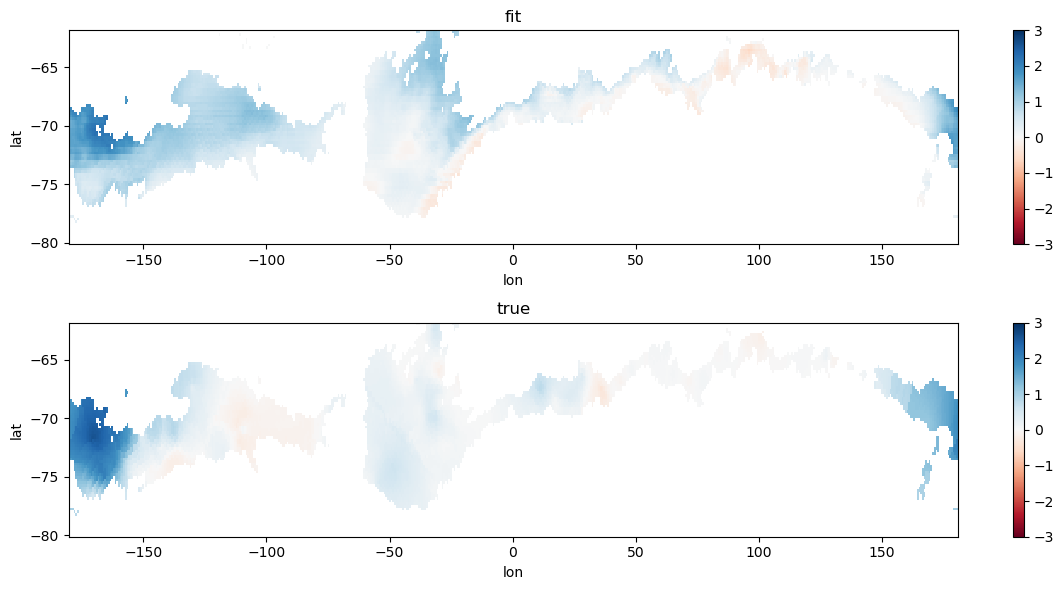

In [17]:
u_fit = u_pred

cmap = plt.cm.RdBu
vmin = -3
vmax = 3

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

plt0 = axs[0].pcolormesh(lon, lat, u_fit[-2, :, :], cmap = cmap ,vmin = vmin, vmax = vmax)
fig.colorbar(plt0, ax = axs[0], label = r'')
axs[0].set_title('fit')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, u_true[-2, :, :], cmap = cmap, vmin = vmin, vmax = vmax)
fig.colorbar(plt1, ax = axs[1], label = r'')
axs[1].set_title('true')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')


fig.tight_layout()

In [19]:
def weighted_skill(fit, true, r):
    
    skill_weighted = 1 - np.nanvar((true - fit) / r, axis = 0) / np.nanvar(true / r, axis = 0)
    
    return skill_weighted

def skill(fit, true):
    
    skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
    # Check where true variance really small!
    
    return skill

In [21]:
r_today, r_mean, r_std = norm(uc_today)

In [23]:
sku = skill(u_fit, u_true)
skv = skill(v_pred, v_true)

skuw = weighted_skill(u_fit, u_true, r_today)
skvw = weighted_skill(v_pred, v_true, r_today)

/tmp/ipykernel_24338/2877293899.py:9: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_24338/2877293899.py:9: RuntimeWarning: invalid value encountered in divide
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_24338/2877293899.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill_weighted = 1 - np.nanvar((true - fit) / r, axis = 0) / np.nanvar(true / r, axis = 0)
/tmp/ipykernel_24338/2877293899.py:3: RuntimeWarning: invalid value encountered in divide
  skill_weighted = 1 - np.nanvar((true - fit) / r, axis = 0) / np.nanvar(true / r, axis = 0)


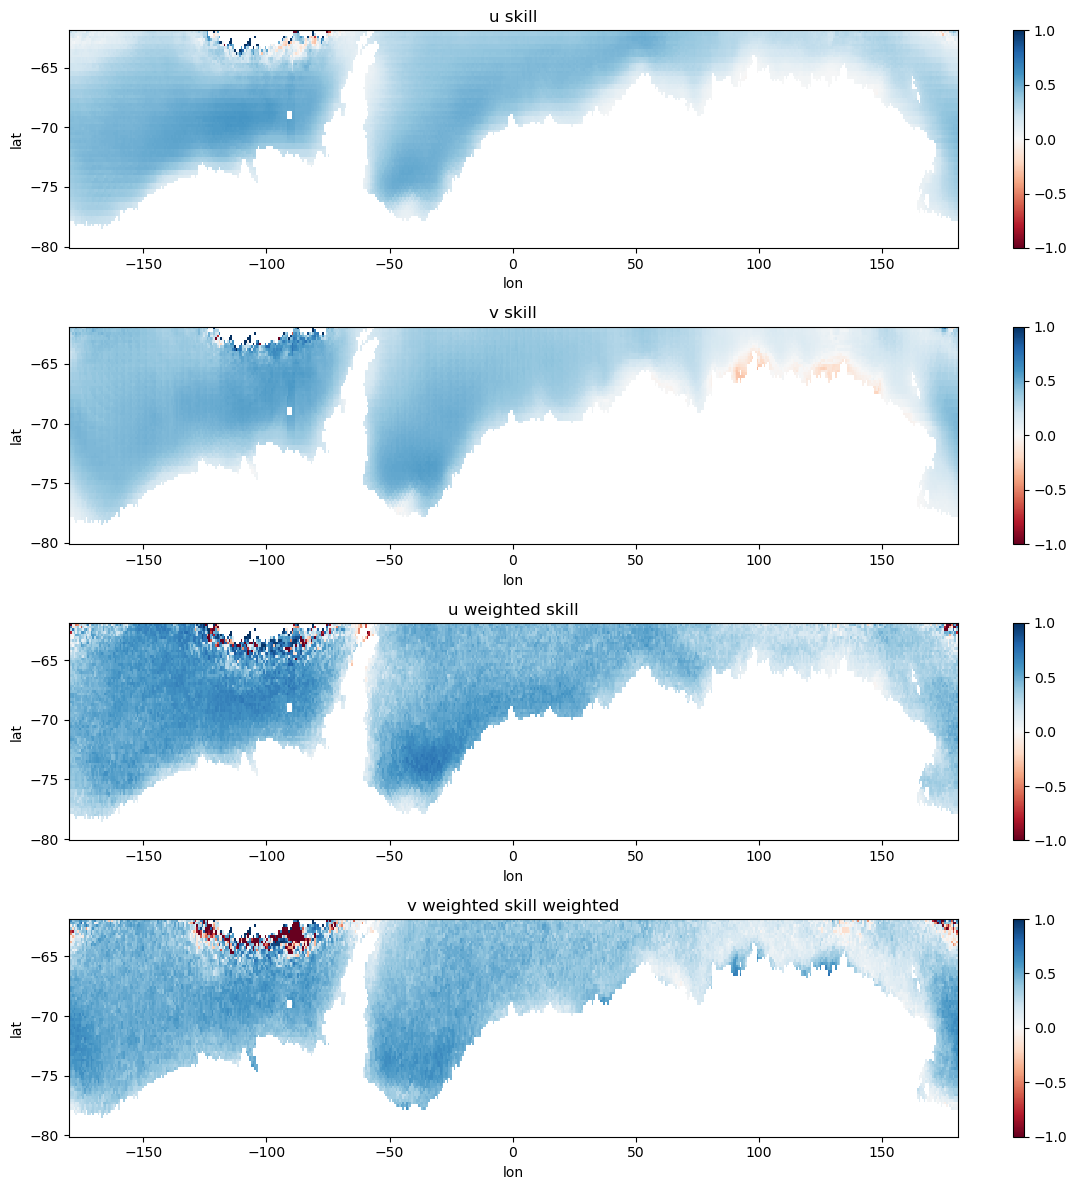

In [25]:
# Plot skill

fig, axs = plt.subplots(nrows = 4, ncols = 1, figsize = (12, 12))

cmap = plt.cm.RdBu

plt0 = axs[0].pcolormesh(lon, lat, sku, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('u skill')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, skv, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('v skill')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

plt2 = axs[2].pcolormesh(lon, lat, skuw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[2])
axs[2].set_title('u weighted skill')
axs[2].set_xlabel('lon')
axs[2].set_ylabel('lat')

plt3 = axs[3].pcolormesh(lon, lat, skvw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[3])
axs[3].set_title('v weighted skill weighted')
axs[3].set_xlabel('lon')
axs[3].set_ylabel('lat')


fig.tight_layout()

In [ ]:
# plt.pcolormesh(np.real(m1))
# plt.title('Zonal Wind Parameter')
# plt.colorbar()
# plt.show()

# plt.pcolormesh(np.imag(m1))
# plt.title('Meridional Wind Parameter')
# plt.colorbar()
# plt.show()

# plt.pcolormesh(np.real(m2))
# plt.title('Concentration Parameter')
# plt.colorbar()
# plt.show()

# plt.pcolormesh(np.imag(m2))
# plt.title('Imaginary Component Concentration Parameter (Set to 0)')
# plt.colorbar()
# plt.show()

In [ ]:
# # Save predicted and true values

# fnam = f"predictions_lr_normalized_1992_2020.npz"

# np.savez_compressed(os.path.join(PATH_DEST, fnam), u_true = u_true, v_true = v_true, u_pred = u_pred, v_pred = v_pred, time = time_today)
# print(f"Variables saved at path {PATH_DEST}/{fnam}")

In [ ]:
# # Multiply by standard deviation and add mean for units cm/s

# ui_true = u_true * ui_std + ui_mean
# vi_true = v_true * vi_std + vi_mean

# ui_pred = u_pred * ui_std + ui_mean
# vi_pred = u_pred * ui_std + ui_mean

In [ ]:
# # Save predicted and true values

# fnam = f"predictions_lr_cms_1992_2020.npz"

# np.savez_compressed(os.path.join(PATH_DEST, fnam), u_true = ui_true, v_true = vi_true, u_pred = ui_pred, v_pred = vi_pred, time = time_today)
# print(f"Variables saved at path {PATH_DEST}/{fnam}")

In [29]:
# Shift present day parameters forward one day
ui_today = ui[1:,:,:]
vi_today = vi[1:,:,:]
uw_today = uw[1:,:,:]
vw_today = vw[1:,:,:]
time_today = time[1:]
uc_today = uc[1:,:,:]

# # Remove last day from previous day parameters
# ui_yester = ui[-1:,:,:]
# vi_yester = vi[-1:,:,:]
ic_yester = ic[:-1,:,:]
time_yester = time[:-1]

In [30]:
# NOTE:
# norm here might be incorrect! 
# The problem could be here that we're normlazing outside of the loop (with the whole grid) without specifiying normalizing accross the time dimension

def norm(data):
    
    data_mean = np.nanmean(data, axis = 0)
    data_std = np.nanstd(data, axis = 0)
    data_norm = (data - data_mean)/data_std
    
    return data_norm, data_mean, data_std

In [31]:
# Normalize data
ui_today, ui_mean, ui_std = norm(ui_today)
vi_today, vi_mean, vi_std = norm(vi_today)
uw_today, uw_mean, uw_std = norm(uw_today)
vw_today, uw_mean, uw_std = norm(vw_today)
ic_yester, ic_mean, ic_std = norm(ic_yester)

/tmp/ipykernel_24338/3496493937.py:7: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis = 0)
/home/jbassham/miniconda3/envs/seaice/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_24338/3496493937.py:9: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean)/data_std


In [32]:
# Create dimensions for arrays based on lat lon grid
dims = np.shape(ui_today)
nt = dims[0]
ny = dims[1]
nx = dims[2]
dim = (ny, nx)

# Initialize fit array
u_true = np.zeros((nt, ny, nx))
v_true = np.zeros((nt, ny, nx))
u_pred = np.zeros((nt, ny, nx))
v_pred = np.zeros((nt, ny, nx))

m1 = np.zeros((dim), dtype=np.complex64) # gridwise model parameter present day wind
m2 = np.zeros((dim), dtype=np.complex64) # gridwise model parameter previous day ice concentration

In [33]:
# Iterate through lat and lon points
for iy in range(len(lat)):
    for ix in range(len(lon)):
        
        # If all NaN values in motion vectors (NaN evaluetes to 'True' b/c not equal to 0)
        if np.all(np.isnan(ui_today[:,iy, ix]) | np.isnan(vi_today[:,iy,ix])):
            # Set arrays equal to NaN and continue to next iteration
            m1[iy,ix] = np.nan
            m2[iy,ix] = np.nan
            
            u_true[:,iy,ix] = np.nan
            v_true[:,iy,ix] = np.nan  
            u_pred[:,iy,ix] = np.nan
            v_pred[:,iy,ix] = np.nan
            
            continue

        else:
            try:          
                # Find NaN indices from ice motion set
                inan = np.where(np.isnan(ui_today[:,iy, ix]) | np.isnan(vi_today[:,iy,ix]))
                
                # Create NaN mask
                # Initialize mask shape of grid (initializes to true - inclusion)
                nmask = np.ones_like(ui_today[:,iy,ix], dtype=bool)
                # Set nan values to false
                nmask[inan] = False
                
                # Filter ice motion
                ui_to = ui_today[nmask,iy,ix]
                vi_to = vi_today[nmask,iy,ix]
                
                # Take Wind and Concentration at same filter indices
                uw_to = uw_today[nmask,iy,ix]
                vw_to = vw_today[nmask,iy,ix]
                
                ic_ye = ic_yester[nmask,iy,ix]
                
                
                # Filter dates non nan
                time_to = time_today[nmask]
                
                # Save in true array
                u_true[nmask, iy, ix] = ui_to
                v_true[nmask, iy, ix] = vi_to
                
                u_true[inan, iy, ix] = np.nan
                v_true[inan, iy, ix] = np.nan
    
                # Convert to complex; 1j is python imaginary operator
                ivel = ui_to + vi_to*1j # Complex Present Day Ice Motion
                w = uw_to + vw_to*1j # Complex Present Day Wind
                ic = ic_ye + 0*1j # Complex Previous Day Concentration (imag comp set to 0)
    
                # Create input G matrix of Wind and Concentration (Transpose)
                G = np.array([w, ic]).T
    
                # Create data matrix of ice motion data points over time
        
                # COMPLEX CONJUGATE TRANSPOSE?!?!?!?!
                d = np.atleast_2d(ivel).T
    
                # Initialize vector of model parameters
                m = np.atleast_2d(np.array([np.zeros(2)])).T
    
                ### LR, No Ridge Parameter *(With Complex Conjugate Transpose)
                # Present Day Wind, Previous day concentration independent
                # Present Day Ice Motion, dependent
                m = (np.linalg.inv(G.conj().T@G))@G.conj().T@d
    
                # Extract Coefficients
                m1[iy,ix] = m[0]
                m2[iy,ix] = m[1]
    
                fit = G@m

                u_pred[nmask, iy, ix] = np.real(fit).flatten()
                v_pred[nmask, iy, ix] = np.imag(fit).flatten()
            
                u_pred[inan, iy, ix] = np.nan
                v_pred[inan, iy, ix] = np.nan
    
            except Exception as e:
                print(f"Error at iy={iy}, ix={ix}: {e}")

    print(f"lat: {iy} complete")

lat: 0 complete
lat: 1 complete
lat: 2 complete
lat: 3 complete
lat: 4 complete
lat: 5 complete
lat: 6 complete
lat: 7 complete


/tmp/ipykernel_24338/777712804.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m1[iy,ix] = m[0]
/tmp/ipykernel_24338/777712804.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m2[iy,ix] = m[1]


lat: 8 complete
lat: 9 complete
lat: 10 complete
lat: 11 complete
lat: 12 complete
lat: 13 complete
lat: 14 complete
lat: 15 complete
lat: 16 complete
lat: 17 complete
lat: 18 complete
lat: 19 complete
lat: 20 complete
lat: 21 complete
lat: 22 complete
lat: 23 complete
lat: 24 complete
lat: 25 complete
lat: 26 complete
lat: 27 complete
lat: 28 complete
lat: 29 complete
lat: 30 complete
lat: 31 complete
lat: 32 complete
lat: 33 complete
lat: 34 complete
lat: 35 complete
lat: 36 complete
lat: 37 complete
lat: 38 complete
lat: 39 complete
lat: 40 complete
lat: 41 complete
lat: 42 complete
lat: 43 complete
lat: 44 complete
lat: 45 complete
lat: 46 complete
lat: 47 complete
lat: 48 complete
lat: 49 complete
lat: 50 complete
lat: 51 complete
lat: 52 complete
lat: 53 complete
lat: 54 complete
lat: 55 complete
lat: 56 complete
lat: 57 complete
lat: 58 complete
lat: 59 complete
lat: 60 complete
lat: 61 complete
lat: 62 complete
lat: 63 complete
lat: 64 complete
lat: 65 complete
lat: 66 complete

In [34]:
sku = skill(u_pred, u_true)
skv = skill(v_pred, v_true)

skuw = weighted_skill(u_fit, u_true, r_today)
skvw = weighted_skill(v_pred, v_true, r_today)

/tmp/ipykernel_24338/2877293899.py:9: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
/tmp/ipykernel_24338/2877293899.py:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill_weighted = 1 - np.nanvar((true - fit) / r, axis = 0) / np.nanvar(true / r, axis = 0)


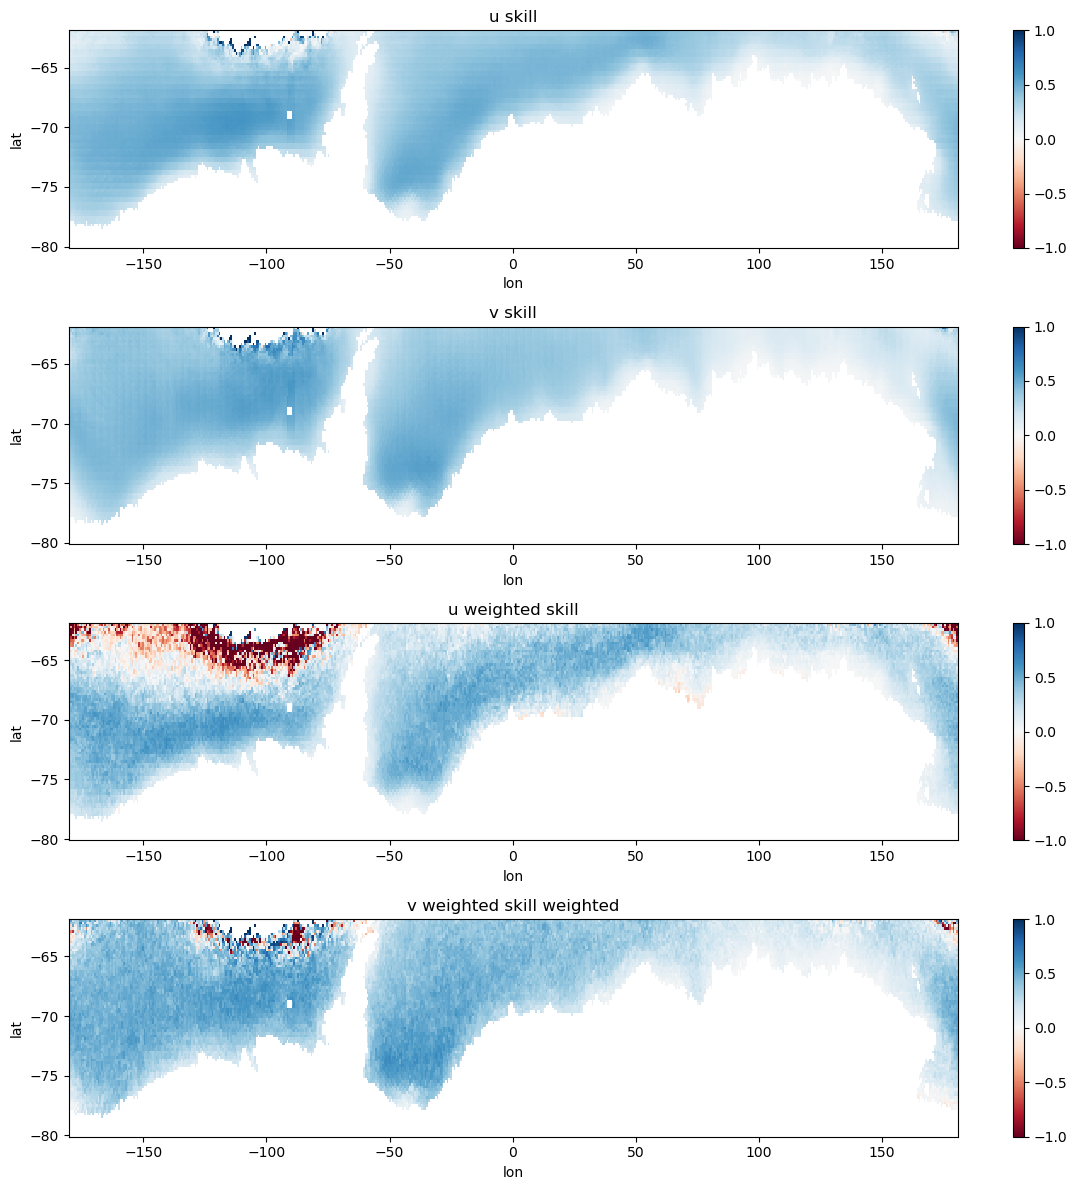

In [35]:
# Plot skill

fig, axs = plt.subplots(nrows = 4, ncols = 1, figsize = (12, 12))

cmap = plt.cm.RdBu

plt0 = axs[0].pcolormesh(lon, lat, sku, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('u skill')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, skv, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('v skill')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')

plt2 = axs[2].pcolormesh(lon, lat, skuw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt0, ax = axs[2])
axs[2].set_title('u weighted skill')
axs[2].set_xlabel('lon')
axs[2].set_ylabel('lat')

plt3 = axs[3].pcolormesh(lon, lat, skvw, cmap = cmap, vmin = -1, vmax = 1)
fig.colorbar(plt1, ax = axs[3])
axs[3].set_title('v weighted skill weighted')
axs[3].set_xlabel('lon')
axs[3].set_ylabel('lat')


fig.tight_layout()